In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
from scipy.stats import chisquare


/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [3]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:, 1]
    
    #data=(data) / np.max(data)  ### valor maximo
    #data=(data - np.min(data)) / (np.max(data) - np.min(data)) ### min-max
    data=(data - np.mean(data)) / np.std(data)
    
    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [4]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(129)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)
    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)
        #data=(data-global_min)/(global_max-global_min)
        data=(data-global_mean)/global_std
        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [5]:
Params={'L': 24, 'P': 0.976656261077567, 'Inh': 0.018217167498983177, 'Trest': -3.887767671371372, 'Trelative': 1.2054348906695989, 'C_h': 8.10720457892007, 'Tipo_red': 2}

initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030, Params["Tipo_red"]]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


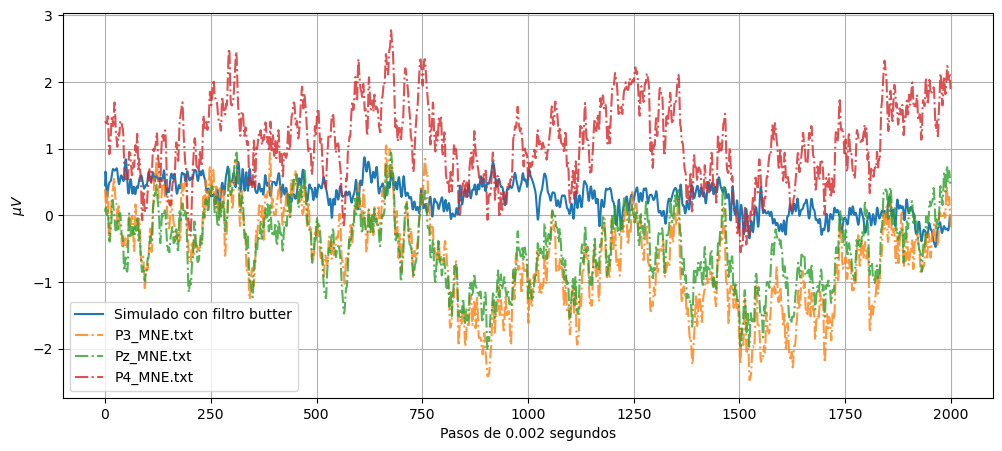

In [6]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"][2:],label="Simulado con filtro butter")
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


[ 0.        1.953125  3.90625   5.859375  7.8125    9.765625 11.71875
 13.671875 15.625    17.578125 19.53125  21.484375 23.4375   25.390625
 27.34375  29.296875 31.25     33.203125 35.15625  37.109375 39.0625
 41.015625 42.96875  44.921875 46.875    48.828125 50.78125  52.734375
 54.6875   56.640625 58.59375  60.546875]
129
129
31
['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']
Delta [-28.516169854533167, 2.568183072353712] ---- [-16.00530718   0.        ]
Theta [-28.44033122275541, 0.22128619707561015] ---- [-19.80021837   0.        ]
Alpha [-32.56701682378237, 1.6081061842104964] ---- [-21.46346384   1.2877738 ]
Beta [-37.32078423507218, 0.8683358651780465] ---- [-28.90850384   1.55043906]


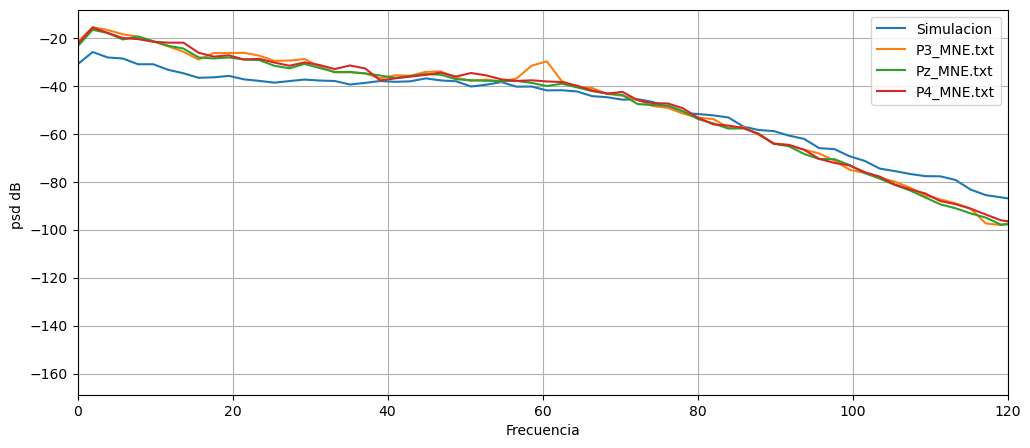

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
print(generated_data["frequencies"][:32])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,120)
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [15]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 50)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
         ### ------------------ Por bandas
        # dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        # dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        # dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        # dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        # difference = (np.sum(np.abs(dif_Delta)) +
        #                     np.sum(np.abs(dif_Theta)) +
        #                     np.sum(np.abs(dif_Alpha)) +
        #                     np.sum(np.abs(dif_Beta)))
        
        ### -------------------- Chi
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:17], f_exp=reales_total["mean_welch"][:17])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name='Chi30_full_zscore', 
                            storage='sqlite:///Estudios/Full_red/chi2/Chi30_full_zscore.db', 
                            load_if_exists=True,pruner=MedianPruner())

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1000)


[I 2024-10-16 22:46:53,955] Using an existing study with name 'Chi30_full_zscore' instead of creating a new one.
/tmp/ipykernel_3808/2890563703.py:28: RuntimeWarning:

invalid value encountered in divide

[I 2024-10-16 22:46:59,733] Trial 2084 finished with value: inf and parameters: {'L': 33, 'P': 0.7288685790707424, 'Inh': 0.9821838092880751, 'Trest': 1.8283140542238332, 'Trelative': 7.51618615146506, 'C_h': 7.561798464481107}. Best is trial 438 with value: 0.6735684383325101.
[I 2024-10-16 22:47:03,493] Trial 2085 finished with value: inf and parameters: {'L': 33, 'P': 0.6997827473862954, 'Inh': 0.9670465913612404, 'Trest': 1.615487421781718, 'Trelative': 5.032789673314896, 'C_h': 7.3120726901448245}. Best is trial 438 with value: 0.6735684383325101.
[I 2024-10-16 22:47:07,344] Trial 2086 finished with value: 10889.522714618395 and parameters: {'L': 32, 'P': 0.7358083541029271, 'Inh': 0.667951355016126, 'Trest': 1.3474842372134315, 'Trelative': 4.531254289128656, 'C_h': 6.2099267175

KeyboardInterrupt: 

In [9]:
# Imprimir el nombre del estudio
print(study.study_name)

# Filtrar los trials válidos
valid_trials = [t for t in study.trials if t.values is not None]

# Obtener los mejores trials en función de uno de los objetivos, por ejemplo, el primero
top_trials = sorted(valid_trials, key=lambda t: t.values[0])[:10]

# Imprimir los mejores trials
for i, trial in enumerate(top_trials):
    print(f"Trial {i}:")
    print(f"  Params: {trial.params}")
    print(f"  Values: {trial.values}")  # Esto ahora devolverá una lista de valores


Chi30_full_zscore
Trial 0:
  Params: {'L': 31, 'P': 0.7112524572168807, 'Inh': 0.9851647656052183, 'Trest': 0.024940070810451492, 'Trelative': 4.768821432145168, 'C_h': 23.90956841701651, 'Tipo_red': 1}
  Values: [0.6735684383325101]
Trial 1:
  Params: {'L': 35, 'P': 0.6366283466207243, 'Inh': 0.9478404540197866, 'Trest': 0.5069542818217241, 'Trelative': 4.047572612411822, 'C_h': 34.56853291051073, 'Tipo_red': 1}
  Values: [0.7239311415097618]
Trial 2:
  Params: {'L': 36, 'P': 0.7515942919876798, 'Inh': 0.9823434169763867, 'Trest': 0.4778253608438614, 'Trelative': 4.3648841973798165, 'C_h': 9.068678007341294, 'Tipo_red': 1}
  Values: [0.8154200033107102]
Trial 3:
  Params: {'L': 34, 'P': 0.6771177548838221, 'Inh': 0.9791350126413788, 'Trest': 0.694480975645936, 'Trelative': 5.381774121519333, 'C_h': 8.202927147296315, 'Tipo_red': 1}
  Values: [0.8379156558017646]
Trial 4:
  Params: {'L': 36, 'P': 0.7845406313087208, 'Inh': 0.9688476405622086, 'Trest': 0.5483053540108219, 'Trelative': 4

In [10]:
vis.plot_param_importances(study)

[W 2024-10-16 20:01:52,866] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,867] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,867] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,867] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,868] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,868] Trial 29 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,868] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,868] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,869] Trial 36 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:01:52,869] Tri

In [11]:
target = lambda trial: trial.values[0]  # Primer objetivo a visualizar

# Ahora puedes graficar el gráfico de coordenadas paralelas
vis.plot_parallel_coordinate(study, target_name='Primer Objetivo')

[W 2024-10-16 20:02:26,253] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,254] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,254] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,254] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,254] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,255] Trial 29 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,255] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,255] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,255] Trial 36 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,256] Tri

In [12]:

# Graficar el gráfico de rebanada
vis.plot_slice(study, target_name='Primer Objetivo')

[W 2024-10-16 20:02:26,478] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,479] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,479] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,479] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,479] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,479] Trial 29 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,480] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,480] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,480] Trial 36 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:26,480] Tri

In [13]:
# Graficar para el segundo objetivo
target_second = lambda trial: trial.values[1]  # Segundo objetivo
vis.plot_slice(study, target_name='Segundo Objetivo')


[W 2024-10-16 20:02:27,040] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,040] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,041] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,041] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,041] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,042] Trial 29 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,042] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,042] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,042] Trial 36 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-16 20:02:27,043] Tri